### pre-process

In [0]:
import pandas as pd
import re
import pickle
import numpy as np
import matplotlib.pyplot as plt
%pylab inline
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

Populating the interactive namespace from numpy and matplotlib


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
def save_obj(obj, name):
    with open('./gdrive/My Drive/Work-3/Q2/obj/' + name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('./gdrive/My Drive/Work-3/Q2/obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [0]:
spelling_mistake_dic = load_obj('sp_mistakes')

In [0]:
path = './gdrive/My Drive/Work-3/Q2/'
train_df = pd.read_csv(path + 'data/train_merged.csv', index_col='id', encoding = 'ISO-8859-1')
test_df = pd.read_csv(path + 'data/test_merged.csv', index_col='id', encoding = 'ISO-8859-1')
features = pd.read_csv(path + 'data/attributes.csv', encoding = 'ISO-8859-1')
sol_df = pd.read_csv(path + 'data/solution.csv', index_col='id', encoding = 'ISO-8859-1')


In [0]:
sol_df = sol_df.loc[sol_df['Usage'] != 'Ignored']
test_df = test_df.merge(sol_df, left_index=True, right_index=True)

In [0]:
def uniform_measurments(s):
    s = re.sub(r"([0-9]+)( *)(inches|inch|in|')\.?", r"\1in. ", s)
    s = re.sub(r"([0-9]+)( *)(foot|feet|ft|'')\.?", r"\1ft. ", s)
    s = re.sub(r"([0-9]+)( *)(pounds|pound|lbs|lb)\.?", r"\1lb. ", s)
    s = re.sub(r"([0-9]+)( *)(square|sq) ?\.?(feet|foot|ft)\.?", r"\1sq.ft. ", s)
    s = re.sub(r"([0-9]+)( *)(cubic|cu) ?\.?(feet|foot|ft)\.?", r"\1cu.ft. ", s)
    s = re.sub(r"([0-9]+)( *)(gallons|gallon|gal)\.?", r"\1gal. ", s)
    s = re.sub(r"([0-9]+)( *)(ounces|ounce|oz)\.?", r"\1oz. ", s)
    s = re.sub(r"([0-9]+)( *)(centimeters|cm)\.?", r"\1cm. ", s)
    s = re.sub(r"([0-9]+)( *)(milimeters|mm)\.?", r"\1mm. ", s)
    s = re.sub(r"([0-9]+)( *)(degrees|degree)\.?", r"\1deg. ", s)
    s = s.replace(" v "," volts ")
    s = re.sub(r"([0-9]+)( *)(volts|volt)\.?", r"\1volt. ", s)
    s = re.sub(r"([0-9]+)( *)(watts|watt)\.?", r"\1watt. ", s)
    s = re.sub(r"([0-9]+)( *)(amperes|ampere|amps|amp)\.?", r"\1amp. ", s)
    return s

In [0]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
def remove_stopwords(sentence):
    stop_words = set(stopwords.words('english'))
    s = [x for x in sentence.split() if x not in stop_words]
    return ' '.join(s)

In [0]:
def stemmer(sentence):
    ps = PorterStemmer()
    s = [ps.stem(x) for x in sentence.split()]
    return ' '.join(s)

In [0]:
def counts_identity(str_to_find, big_str):
    sum = 0
    if (str(str_to_find) == 'nan' ):
        return 0
    
    big_str = str(big_str)
    for text in str_to_find.split():
        
        if text in big_str.split():
            sum = sum + 1
    return sum

def calculate_identity_column(data1,data2):
    new_col = np.zeros(data1.shape)
    for i in range(len(new_col)):
        new_col[i] = counts_identity(data1[i],data2[i])
    return pd.Series(new_col)

In [0]:
def calculate_len_column(data1):
    new_col = np.zeros(data1.shape)
    for i in range(len(new_col)):
        new_col[i] = len(data1[i])
    return pd.Series(new_col)

In [0]:
def feature_engineering(df):
    brand_df = features[features['name'] == 'MFG Brand Name'][["product_uid", "value"]].rename(columns={"value": "Brand_name"})
    df = df.reset_index().merge(brand_df, on='product_uid', how = 'left').set_index('id')
    df = df.fillna('Nan')
    #material_fd = features[features['name'] == 'Material'][["product_uid", "value"]].rename(columns={"value": "Material"})
    #df = df.merge(material_fd, on='product_uid',how='left',right_index=True)
    
    return df

In [0]:
def data_preprocess(df):
    ### feature engineering
    df = feature_engineering(df)
    
    ### to lowercase
    df['search_term'] = df['search_term'].str.lower()
    df['product_title'] = df['product_title'].str.lower()
    df['product_description'] = df['product_description'].str.lower()
    df['Brand_name'] = df['Brand_name'].str.lower()
    #df['Material'] = df['Material'].str.lower()
    
    ### fix search term spelling mistakes
    df['search_term'] = df['search_term'].apply(lambda x: spelling_mistake_dic[x] if x in spelling_mistake_dic.keys() else x)
    
    ### uniform measurments
    df['search_term'] = df['search_term'].apply(lambda x: uniform_measurments(x))
    df['product_title'] = df['product_title'].apply(lambda x: uniform_measurments(x))
    df['product_description'] = df['product_description'].apply(lambda x: uniform_measurments(x))
    
    ### punctuation
    df['search_term'] = df['search_term'].apply(lambda x: re.sub('~|=|:|_|\?|;|\*|&|,|-',' ',x))
    df['product_description'] = df['product_description'].apply(lambda x: re.sub('^|>|}|{|\'|\[|\]|@|<|,|\*|\?|!|_|=|;|-',' ', x))
    df['product_title'] = df['product_title'].apply(lambda x: re.sub('^|>|}|{|\'|\[|\]|@|<|,|\*|\?|!|_|=|;|-',' ', x))
    df['Brand_name'] = df['Brand_name'].apply(lambda x: re.sub('^|>|}|{|\'|\[|\]|@|<|,|\*|\?|!|_|=|;|-|-',' ', str(x)))
    #df['Material'] = df['Material'].apply(lambda x: re.sub('^|>|}|{|\'|\[|\]|@|<|,|\*|\?|!|_|=|;|-|-',' ', str(x)))
    
    ### remove html tags
    df['product_description'] = df['product_description'].apply(lambda x: BeautifulSoup(x, "html.parser").get_text(separator=" "))
    
    ### remove stopwords
    df['search_term'] = df['search_term'].apply(lambda x: remove_stopwords(x))
    df['product_description'] = df['product_description'].apply(lambda x: remove_stopwords(x))
    df['product_title'] = df['product_title'].apply(lambda x: remove_stopwords(x))
    
    ### stemming
    df['search_term'] = df['search_term'].apply(lambda x: stemmer(x))
    df['product_description'] = df['product_description'].apply(lambda x: stemmer(x))
    df['product_title'] = df['product_title'].apply(lambda x: stemmer(x))
    df['Brand_name'] = df['Brand_name'].apply(lambda x: stemmer(x))
    #df['Material'] = df['Material'].apply(lambda x: stemmer(x))
    
    ### identity
    df['product_title_identity'] = calculate_identity_column(df.search_term.values, df.product_title.values).values
    
    df['product_desc_identity'] = calculate_identity_column(df.search_term.values, df.product_description.values).values
    
    df['product_brand_identity'] = calculate_identity_column(df.search_term.values, df.Brand_name.values).values

    #df['product_material_identity'] = calculate_identity_column(df.search_term.values, df.Material.values)
    
    
    ### length
    df['product_title_length'] = calculate_len_column(df.product_title.values).values
    
    df['product_desc_length'] = calculate_len_column(df.product_description.values).values
    

    
    ### add title to description
    df['product_description'] = df['product_title'] + ' ' + df['product_description']
    
    ### drop title
    df = df.drop(['product_title'],axis=1)
    
    return df 

In [0]:
train_df = data_preprocess(train_df)
test_df = data_preprocess(test_df)

In [0]:
train_df.to_csv(path + 'data/train_ready.csv', index_label='id', encoding = 'ISO-8859-1')
test_df.to_csv(path + 'data/test_ready.csv', index_label='id', encoding = 'ISO-8859-1')

### build dictionary

In [0]:
import numpy as np
import pandas as pd
from keras.preprocessing.sequence import pad_sequences
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

def min_max_mean(data,title=''):
    sns.distplot([len(s) for s in data], kde=False)
    plt.title(title)
    plt.xlabel('#num of rows')
    plt.ylabel('#num of characters')
    print('min length: {}'.format(min([len(s) for s in data])))
    print('max length: {}'.format(max([len(s) for s in data])))
    print('mean length: {}'.format(mean([len(s) for s in data])))
    print('median length: {}'.format(median([len(s) for s in data])))

Using TensorFlow backend.


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


min length: 150
max length: 4046
mean length: 704.9443206826252
median length: 613.0


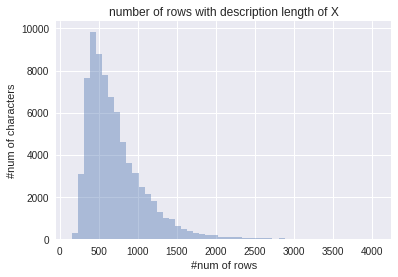

In [0]:
min_max_mean(train_df.product_description.values, 'number of rows with description length of X')

we will choose peoduct description length to be a little bit above the median: 650

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


min length: 2
max length: 34
mean length: 7.826737953474557
median length: 7.0


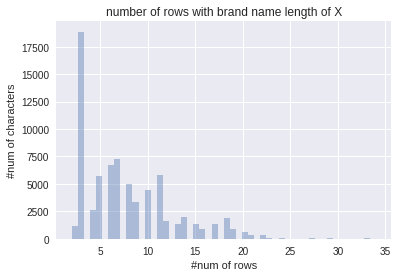

In [0]:
min_max_mean(train_df.Brand_name.values, 'number of rows with brand name length of X')

as we can see there are huge number of brands with 2 words, the max is 34 and the median is 7. we will use 7 in order to avoid noise (with many 0's) but also not to miss many rows data.

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


min length: 0
max length: 55
mean length: 17.12419836094347
median length: 17.0


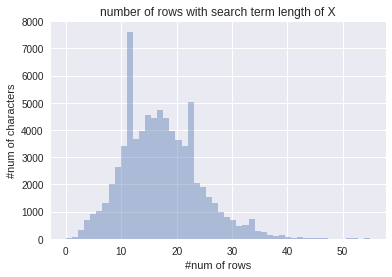

In [0]:
min_max_mean(train_df.search_term.values, 'number of rows with search term length of X')

we will use length of 20. (in order to take the high pike)

In [0]:
#vec_len_material = 3
vec_len_brands = 3
vec_len_product_desc = 613
vec_search_term = 18

we will use tokenizer:

In [0]:
#tokenizer = Tokenizer(filters='')
tokenizer = load_obj('final_tok')

In [0]:
def to_seq(data,length):
    tokenizer.fit_on_texts(data) # add to tokenizer dict
    encoded_docs = tokenizer.texts_to_sequences(data) # text to numerical (by index)
    return pad_sequences(encoded_docs, maxlen=length, padding='post')

In [0]:
x = train_df[['search_term','product_description', 'Brand_name']]
y = train_df[['relevance']]
Xtrain_desc = to_seq(train_df.product_description.values,vec_len_product_desc)
Xtrain_brands = to_seq(train_df.Brand_name.values, vec_len_brands)
Xtrain_search_term = to_seq(train_df.search_term.values, vec_search_term)


In [0]:
Xtest_desc = to_seq(test_df.product_description.values,vec_len_product_desc)
Xtest_brands = to_seq(test_df.Brand_name.values, vec_len_brands)
Xtest_search_term = to_seq(test_df.search_term.values, vec_search_term)

Ytest = test_df.relevance.values

In [0]:
save_obj(tokenizer,'final_tok')

## form models

### validation strategy

we tried many different validation sets to create the validation set in such a way that describe the best the test set.  
*	as we noticed at the exploration part by the Venn diagram, there is 22% of the products that exist in both the train and test set, and the others exist only in one of the sets. we wanted to retain this percentage between the train and validation sets as well.
*	we also notice that the relevance in the train set is not balanced, there are many rows that voted with ~2.5 and few the voted ~1.5 so we decided that it will be clever to split the train and validation and save this proportion of votes. (like stratified fold do)


In [0]:
trainend = int(len(train_df)*0.885)
counts = train_df.reset_index()[:trainend].groupby(['product_uid']).count()[['id']]

counts = counts[counts['id'] > 1]
counts = counts.add_suffix('_Count').reset_index()
valid_product_uids = set(counts['product_uid'].values)

inds = []

allowed_uids = train_df.reset_index().loc[train_df.reset_index()['product_uid'].isin(valid_product_uids)]
lastUid = 0

for idx, mrow in allowed_uids.iterrows():
    if lastUid == mrow['product_uid']:
        continue

    lastUid = mrow['product_uid']
    inds.append(idx)

test_inds = inds + list(train_df.reset_index()[trainend:].index.values)
train_inds = list(train_df.reset_index().loc[~train_df.reset_index().index.isin(test_inds)].index.values)

print("Train: "+str(len(train_inds))+", test: "+str(len(test_inds)))


Train: 53907, test: 20160


Text(0.5, 1.0, 'Search_term venn diagram')

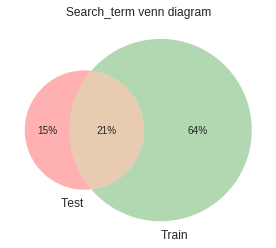

In [0]:
import matplotlib_venn as venn
set_testId = set(train_df.product_uid.values[test_inds])
set_trainId = set(train_df.product_uid.values[train_inds])
total = len(set_testId) + len(set_trainId) - len(set_testId.intersection(set_trainId))
venn.venn2([set_testId, set_trainId],['Test','Train'], alpha=0.3, subset_label_formatter=lambda x: f"{(x/total):1.0%}")
plt.title('Search_term venn diagram')

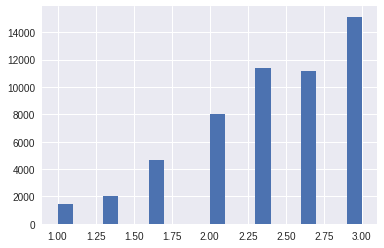

In [0]:
train_df.iloc[train_inds].relevance.hist(bins=20)

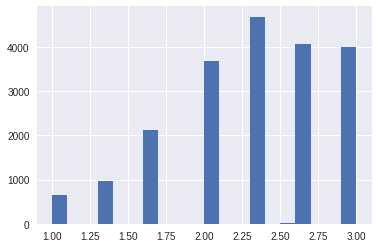

In [0]:
train_df.iloc[test_inds].relevance.hist(bins=20)

### imports and helper functions

In [0]:
import keras 
from keras.layers import Dense, LSTM, Embedding, MaxPooling2D, Convolution2D, Dropout, Input, Flatten, Subtract, merge, Concatenate, Lambda, BatchNormalization
from keras.models import Model
from keras import backend as K
import tensorflow as tf
from sklearn import preprocessing
from keras.preprocessing.text import Tokenizer
from time import time
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error
from math import sqrt
from keras import backend as K
from keras.optimizers import SGD
from keras import Sequential

In [0]:
def set_callbacks(description='run1',patience=6,tb_base_logdir='./logs/',model_num = ''):
    cp = ModelCheckpoint(path  + 'models/model' + model_num +'/weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', save_best_only=False)
    es = EarlyStopping(patience=patience,monitor='val_loss')   
    reduce_lr_loss = ReduceLROnPlateau(monitor='loss',factor=0.1, patience=3, verbose=1, epsilon=1e-3)
    cb = [cp,es,reduce_lr_loss]
    return cb

In [0]:

def rmse(actual,predicted):
    return sqrt(mse(actual,predicted))
def mae(actual,predicted):
    return mae(actual,predicted)

def exponent_neg_manhattan_distance(left, right):
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))  

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

In [0]:
_columns=['Model type','runtime','Train RMSE','Val-RMSE','Test-RMSE','Train MAE','Val-MAE','Test-MAE']
results_table = pd.DataFrame(columns=_columns)

def update_result_table(model_type,runtime,train_pred,actual_train,val_pred,actual_val,test_pred,actual_test):
  global results_table
  train_rmse = rmse(actual_train, train_pred)  
  val_rmse = rmse(actual_val, val_pred)
  test_rmse = rmse(actual_test, test_pred)
  train_mae = mean_absolute_error(actual_train, train_pred) 
  val_mae = mean_absolute_error(actual_val, val_pred)
  test_mae = mean_absolute_error(actual_test, test_pred)
  results_table = results_table.append(pd.Series([model_type,runtime,train_rmse,val_rmse,test_rmse,train_mae,val_mae,test_mae], index = _columns),ignore_index=True)
  save_obj(results_table, 'results_table')

In [0]:
def plot_history(history):
  
  fig, axs = plt.subplots(1,1,figsize=(10,5))
  axs.plot(range(1,len(history['loss'])+1),history['loss'])
  axs.plot(range(1,len(history['val_loss'])+1),history['val_loss'])
  axs.set_title('Model Loss')
  axs.set_ylabel('Loss')
  axs.set_xlabel('Epoch')
  axs.legend(['train', 'val'])
  plt.show()

In [0]:
def analyze_pred(pred, real):
  
  print('min pred: {} \nmax prediction: {} \n'.format(min(pred), max(pred)))

  fig, axes = plt.subplots(nrows=1, ncols=2)
  (ax0, ax1) = axes.flatten()

  ax0.hist(pred, density=True, histtype='bar')
  ax0.set_title('predictions')

  ax1.hist(real, density=True, histtype='bar')
  ax1.set_title('real rate')

  fig.tight_layout()
  plt.show()

### create embedding weights

first we try to train model with embedding, we use the following embeddings:
* GoogleNews
* Glove

In [0]:
def load_embedding(filename):
    file = open(path + 'obj/' + filename,'r', encoding='utf8')
    lines = file.readlines()
    file.close()
    embedding = dict()
    for line in lines:
        parts = line.split()
        embedding[parts[0]] = asarray(parts[1:], dtype='float32')
    return embedding

In [0]:
def get_weight_matrix_Google(embedding, vocab):
    vocab_size = len(vocab) + 1
    weight_matrix = np.random.rand(vocab_size, 300)
    for word, i in vocab.items():
        if word in embedding:
            weight_matrix[i] = embedding.get_vector(word)
    return weight_matrix
  
def get_weight_matrix_glove(embedding, vocab):
    vocab_size = len(vocab) + 1
    weight_matrix = np.random.rand(vocab_size, 100)
    for word, i in vocab.items():
        vector = embedding.get(word)
        if vector is not None:
          weight_matrix[i] = vector
    return weight_matrix

to load GoogleNews vectors:

In [0]:
import gensim

EMBEDDING_FILE = path + 'obj/GoogleNews-vectors-negative300.bin'
embeddings_index = gensim.models.KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)
embedding_vectors_google = get_weight_matrix_Google(embeddings_index, tokenizer.word_index)

to load glove:

In [0]:
raw_embedding = load_embedding('glove.6B.100d.txt')
embedding_vectors_glove = get_weight_matrix_glove(raw_embedding, tokenizer.word_index)

### google embedding model

In [0]:
def build_model_with_embeddings(_type = 'None'):
  term_input = Input(shape=(vec_search_term,), name='term_input')
  product_input = Input(shape=(vec_len_product_desc,), name='product_input')
  
  if _type == 'google':
    embedding_layer = Embedding(len(tokenizer.word_index)+1, 300 ,weights=[embedding_vectors_google], trainable=True)
  elif _type == 'glove':
    embedding_layer = Embedding(len(tokenizer.word_index)+1, 100 ,weights=[embedding_vectors_glove], trainable=True)
  else:
    embedding_layer = Embedding(len(tokenizer.word_index)+1, 10, trainable=True)
  
  shared_lstm = Sequential(name='shared_model')
  shared_lstm.add(embedding_layer)
  shared_lstm.add(LSTM(100, return_sequences=False))
  shared_lstm.add(Dense(100, activation='relu')) 
  shared_lstm.add(Dense(100, activation='relu'))
  
  output = Lambda(function=lambda x: 2*(exponent_neg_manhattan_distance(x[0], x[1]))+1,
                  output_shape=lambda x: (x[0][0], 1),
                  name='prediction')([shared_lstm(term_input), shared_lstm(product_input)])

  model = Model(inputs=[term_input,product_input], outputs=[output])
  optimizer = SGD(lr=0.001, momentum=0.9, nesterov=True, clipvalue=1.)
  model.compile(loss='mse', optimizer=optimizer, metrics=['mae',root_mean_squared_error])
  model.summary()
  return model

In [0]:
siamese_using_google_embedding = build_model_with_embeddings('google')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
term_input (InputLayer)         (None, 18)           0                                            
__________________________________________________________________________________________________
product_input (InputLayer)      (None, 613)          0                                            
__________________________________________________________________________________________________
shared_model (Sequential)       (None, 100)          98855700    term_input[0][0]                 
                                                                 product_input[0][0]              
__________________________________________________________________________________________________
prediction (Lambda)             (None, 1)            0           shared_model[1][0]               
          

In [0]:
training_start_time = time()
history = siamese_using_google_embedding.fit([Xtrain_search_term[train_inds], Xtrain_desc[train_inds]], 
                                     y.values[train_inds], 
                                     validation_data=[[Xtrain_search_term[test_inds], Xtrain_desc[test_inds]], y.values[test_inds]], 
                                     epochs=80, batch_size=1024, callbacks=set_callbacks(model_num = str(38)))
  
training_end_time = time()
print('running time: {}'.format((training_end_time-training_start_time)/60))

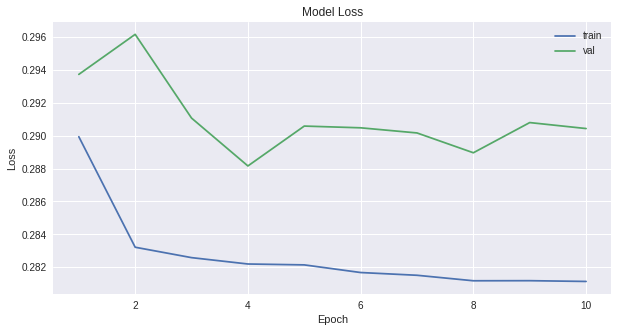

In [0]:
history = load_obj('history_siamese_using_embeddings_google')
plot_history(history)

In [0]:
siamese_using_google_embedding.load_weights(path + 'models/model38/weights.04-0.29.hdf5')

In [0]:
train_prediction = siamese_using_google_embedding.predict([Xtrain_search_term[train_inds], Xtrain_desc[train_inds]])
valid_prediction = siamese_using_google_embedding.predict([Xtrain_search_term[test_inds], Xtrain_desc[test_inds]])
test_prediction = siamese_using_google_embedding.predict([Xtest_search_term, Xtest_desc])
update_result_table('siamese using Google embeddings', 
                   round((training_end_time-training_start_time)/60), 
                   train_prediction, y.values[train_inds],
                   valid_prediction, y.values[test_inds],
                   test_prediction, test_df.relevance.values)
siamese using Google embeddings	21	0.531161	0.536808	0.536570	0.437928	0.432741	0.439500

,Model type,runtime,Train RMSE,Val-RMSE,Test-RMSE,Train MAE,Val-MAE,Test-MAE
0,siamese using Google embeddings,21,0.531161,0.536808,0.53657,0.437928,0.432741,0.4395


min pred: 1.017370343208313 
max prediction: 2.593496799468994 



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9d413ff940>]],
      dtype=object)

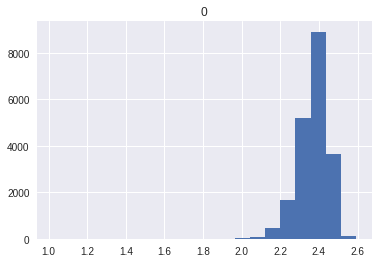

In [0]:
print('min pred: {} \nmax prediction: {} \n'.format(min(valid_prediction)[0], max(valid_prediction)[0]))
pd.DataFrame(valid_prediction).hist(bins=20)

### glove embeddings model

In [0]:
siamese_using_glove_embedding = build_model_with_embeddings('glove')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
term_input (InputLayer)         (None, 18)           0                                            
__________________________________________________________________________________________________
product_input (InputLayer)      (None, 613)          0                                            
__________________________________________________________________________________________________
shared_model (Sequential)       (None, 100)          32992300    term_input[0][0]                 
                                                                 product_input[0][0]              
__________________________________________________________________________________________________
prediction (Lambda)             (None, 1)            0           shared_model[1][0]               
          

In [0]:
training_start_time = time()
history = siamese_using_glove_embedding.fit([Xtrain_search_term[train_inds], Xtrain_desc[train_inds]], 
                                     y.values[train_inds], 
                                     validation_data=[[Xtrain_search_term[test_inds], Xtrain_desc[test_inds]], y.values[test_inds]], 
                                     epochs=80, batch_size=1024, callbacks=set_callbacks(model_num = str(39)))
  
training_end_time = time()
print('running time: {}'.format((training_end_time-training_start_time)/60))

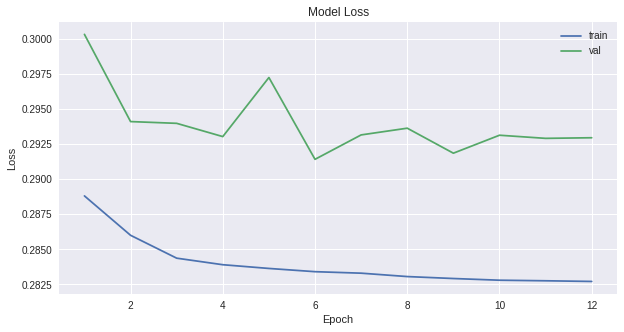

In [0]:
history = load_obj('history_siamese_using_embeddings_glove')
plot_history(history)

In [0]:
siamese_using_glove_embedding.load_weights(path + 'models/model39/weights.06-0.29.hdf5')

In [0]:
train_prediction = siamese_using_google_embedding.predict([Xtrain_search_term[train_inds], Xtrain_desc[train_inds]])
valid_prediction = siamese_using_glove_embedding.predict([Xtrain_search_term[test_inds], Xtrain_desc[test_inds]])
test_prediction = siamese_using_google_embedding.predict([Xtest_search_term, Xtest_desc])
update_result_table('siamese using Glove embeddings', 
                   round((training_end_time-training_start_time)/60), 
                   train_prediction, y.values[train_inds],
                   valid_prediction, y.values[test_inds],
                   test_prediction, test_df.relevance.values)

,Model type,runtime,Train RMSE,Val-RMSE,Test-RMSE,Train MAE,Val-MAE,Test-MAE
0,siamese using Google embeddings,21,0.531161,0.536808,0.536570,0.437928,0.432741,0.439500
1,siamese using Glove embeddings,21,0.532119,0.539829,0.537811,0.438348,0.434985,0.439731


min pred: 1.1231247186660767 
max prediction: 2.573237657546997 



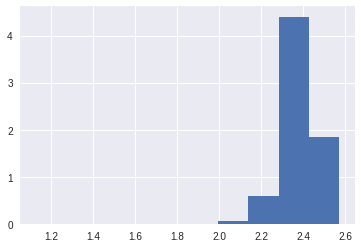

In [0]:
def plot_pred_dist(pred):
  print('min pred: {} \nmax prediction: {} \n'.format(min(pred)[0], max(pred)[0]))
  plt.hist(pred, density=True, histtype='bar')
  
plot_pred_dist(valid_prediction)

### learn embedding weights

In [0]:
siamese_using_not_pretrained_embeddings = build_model_with_embeddings()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
term_input (InputLayer)         (None, 18)           0                                            
__________________________________________________________________________________________________
product_input (InputLayer)      (None, 613)          0                                            
__________________________________________________________________________________________________
shared_model (Sequential)       (None, 100)          3353770     term_input[0][0]                 
                                                                 product_input[0][0]              
__________________________________________________________________________________________________
prediction (Lambda)             (None, 1)            0           shared_model[1][0]               
          

In [0]:
training_start_time = time()
history = siamese_using_not_pretrained_embeddings.fit([Xtrain_search_term[train_inds], Xtrain_desc[train_inds]], 
                                     y.values[train_inds], 
                                     validation_data=[[Xtrain_search_term[test_inds], Xtrain_desc[test_inds]], y.values[test_inds]], 
                                     epochs=80, batch_size=1024, callbacks=set_callbacks(model_num = str(40)))
  
training_end_time = time()
print('running time: {}'.format((training_end_time-training_start_time)/60))

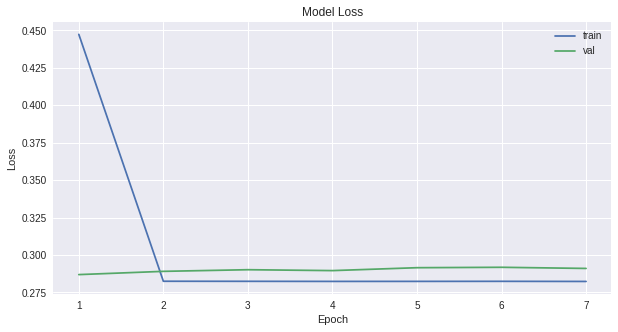

In [0]:
history = load_obj('history_siamese_using_embeddings_not_pretrained')
plot_history(history)

In [0]:
siamese_using_not_pretrained_embeddings.load_weights(path + 'models/model40/weights.02-0.29.hdf5')

In [0]:
train_prediction = siamese_using_google_embedding.predict([Xtrain_search_term[train_inds], Xtrain_desc[train_inds]])
valid_prediction = siamese_using_not_pretrained_embeddings.predict([Xtrain_search_term[test_inds], Xtrain_desc[test_inds]])
test_prediction = siamese_using_google_embedding.predict([Xtest_search_term, Xtest_desc])
update_result_table('siamese using not pretrained embeddings', 
                   round((training_end_time-training_start_time)/60), 
                   train_prediction, y.values[train_inds],
                   valid_prediction, y.values[test_inds],
                   test_prediction, test_df.relevance.values)
results_table

,Model type,runtime,Train RMSE,Val-RMSE,Test-RMSE,Train MAE,Val-MAE,Test-MAE
0,siamese using Google embeddings,21,0.531161,0.536808,0.536570,0.437928,0.432741,0.439500
1,siamese using Glove embeddings,21,0.532119,0.539829,0.537811,0.438348,0.434985,0.439731
2,siamese using not pretrained embeddings,12,0.532115,0.535606,0.534717,0.438177,0.430251,0.437226


min pred: 2.007314920425415 
max prediction: 2.468079090118408 



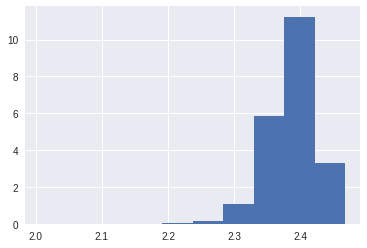

In [0]:
plot_pred_dist(valid_prediction)


### model without embedding

shape the data:  
(num of samples, sequence of words, unit)

In [0]:
Xtrain_desc = Xtrain_desc.reshape((Xtrain_desc.shape[0],vec_len_product_desc, 1))
Xtrain_search_term = Xtrain_search_term.reshape((Xtrain_search_term.shape[0], vec_search_term, 1))

print('X_train search_term shape: {}'.format(Xtrain_search_term.shape))
print('X_train product_description shape: {} '.format(Xtrain_desc.shape))

Xtest_search_term = Xtest_search_term.reshape((Xtest_search_term.shape[0], Xtest_search_term.shape[1], 1))
Xtest_desc = Xtest_desc.reshape((Xtest_desc.shape[0], Xtest_desc.shape[1], 1))

print('X_test search_term shape: {}'.format(Xtest_search_term.shape))
print('X_train product_description shape: {}'.format(Xtest_desc.shape))

X_train search_term shape: (74067, 18, 1)
X_train product_description shape: (74067, 613, 1) 
X_test search_term shape: (112067, 18, 1)
X_train product_description shape: (112067, 613, 1)


In [0]:
def build_model_without_embeddings():
  term_input = Input(shape=(vec_search_term,1), name='term_input')
  product_input = Input(shape=(vec_len_product_desc,1), name='product_input')
  
  
  shared_lstm = Sequential(name='shared_model')
  shared_lstm.add(LSTM(100, return_sequences=False))
  shared_lstm.add(Dense(100, activation='relu')) 
  shared_lstm.add(Dense(100, activation='relu'))
  
  output = Lambda(function=lambda x: 2*(exponent_neg_manhattan_distance(x[0], x[1]))+1,
                  output_shape=lambda x: (x[0][0], 1),
                  name='prediction')([shared_lstm(term_input), shared_lstm(product_input)])

  model = Model(inputs=[term_input,product_input], outputs=[output])
  optimizer = SGD(lr=0.001, momentum=0.9, nesterov=True, clipvalue=1.)
  model.compile(loss='mse', optimizer=optimizer, metrics=['mae',root_mean_squared_error])
  model.summary()
  return model

In [0]:
siamese_model_no_emb = build_model_without_embeddings()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
term_input (InputLayer)         (None, 18, 1)        0                                            
__________________________________________________________________________________________________
product_input (InputLayer)      (None, 613, 1)       0                                            
__________________________________________________________________________________________________
shared_model (Sequential)       (None, 100)          61000       term_input[0][0]                 
                                                                 product_input[0][0]              
__________________________________________________________________________________________________
prediction (Lambda)             (None, 1)            0           shared_model[1][0]               
          

In [0]:
training_start_time = time()
  
history = siamese_model_no_emb.fit([Xtrain_search_term[train_inds], Xtrain_desc[train_inds]], 
                                     y.values[train_inds], 
                                     validation_data=[[Xtrain_search_term[test_inds], Xtrain_desc[test_inds]], y.values[test_inds]], 
                                     epochs=80, batch_size=1024, callbacks=set_callbacks(model_num = str(37)))
  
training_end_time = time()
print('running time: {}'.format((training_end_time-training_start_time)/60))

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


Train on 53907 samples, validate on 20160 samples
Epoch 1/80
53907/53907 [==============================] - 91s 2ms/step - loss: 0.2927 - mean_absolute_error: 0.4428 - root_mean_squared_error: 0.4428 - val_loss: 0.2990 - val_mean_absolute_error: 0.4393 - val_root_mean_squared_error: 0.4393
Epoch 2/80
53907/53907 [==============================] - 84s 2ms/step - loss: 0.2839 - mean_absolute_error: 0.4375 - root_mean_squared_error: 0.4375 - val_loss: 0.2916 - val_mean_absolute_error: 0.4334 - val_root_mean_squared_error: 0.4334
Epoch 3/80
53907/53907 [==============================] - 84s 2ms/step - loss: 0.2826 - mean_absolute_error: 0.4368 - root_mean_squared_error: 0.4368 - val_loss: 0.2930 - val_mean_absolute_error: 0.4349 - val_root_mean_squared_error: 0.4349
Epoch 4/80
53907/53907 [==============================] - 84s 2ms/step - loss: 0.2820 - mean_absolute_error: 0.4361 - root_mean_squared_error: 0.4361 - val_loss: 0.2918 - val_mean_absolute_error: 0.4338 - val_root_mean_squared_

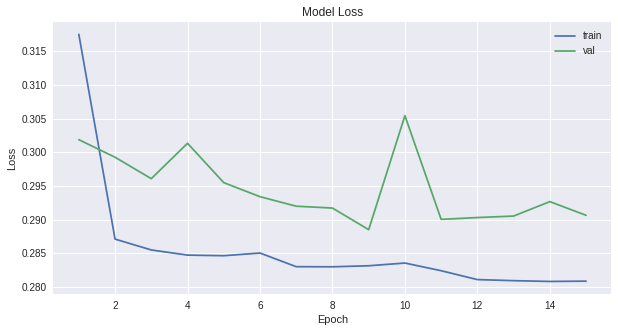

In [0]:
history = load_obj('history_siamese_model_no_emb')
plot_history(history)

In [0]:
siamese_model_no_emb.load_weights(path + 'models/model36/weights.09-0.29.hdf5')

In [0]:
train_prediction = siamese_model_no_emb.predict([Xtrain_search_term[train_inds], Xtrain_desc[train_inds]])
valid_prediction = siamese_model_no_emb.predict([Xtrain_search_term[test_inds], Xtrain_desc[test_inds]])
test_prediction = siamese_model_no_emb.predict([Xtest_search_term, Xtest_desc])
update_result_table('siamese model without emb', 
                    round((training_end_time-training_start_time)/60), 
                   train_prediction, y.values[train_inds],
                   valid_prediction, y.values[test_inds],
                   test_prediction, test_df.relevance.values)
results_table 

,Model type,runtime,Train RMSE,Val-RMSE,Test-RMSE,Train MAE,Val-MAE,Test-MAE
0,siamese using Google embeddings,21,0.531161,0.536808,0.536570,0.437928,0.432741,0.439500
1,siamese using Glove embeddings,21,0.532119,0.539829,0.537811,0.438348,0.434985,0.439731
2,siamese using not pretrained embeddings,12,0.532115,0.535606,0.534717,0.438177,0.430251,0.437226
3,siamese model without emb,20,0.530884,0.537128,0.534985,0.436286,0.431503,0.436756


min pred: 1.0000182390213013 
max prediction: 2.943058490753174 



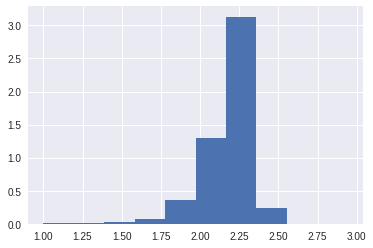

In [0]:
plot_pred_dist(valid_prediction)

### Best model - siamese model without embedding - NOW lets try to add brand feature and check if it is improve the results

In [0]:
Xtrain_brands = Xtrain_brands.reshape((Xtrain_brands.shape[0], vec_len_brands, 1))
print('X_train brands shape: {} '.format(Xtrain_brands.shape))

Xtest_brands = Xtest_brands.reshape((Xtest_brands.shape[0], Xtest_brands.shape[1], 1))

print('Xtest brands shape: {}'.format(Xtest_brands.shape))

X_train brands shape: (74067, 3, 1) 
Xtest brands shape: (112067, 3, 1)


In [0]:
def build_model_without_embeddings_with_brands():
  term_input = Input(shape=(vec_search_term,1), name='term_input')
  product_input = Input(shape=(vec_len_product_desc,1), name='product_input')
  brand_input = Input(shape=(vec_len_brands,1), name='brand_input')
  
  con = Concatenate(axis=1)([product_input, brand_input])
  
  shared_lstm = Sequential(name='shared_model')
  shared_lstm.add(LSTM(100, return_sequences=False))
  shared_lstm.add(Dense(100, activation='relu')) 
  shared_lstm.add(Dense(100, activation='relu'))
  
  output = Lambda(function=lambda x: 2*(exponent_neg_manhattan_distance(x[0], x[1]))+1,
                  output_shape=lambda x: (x[0][0], 1),
                  name='prediction')([shared_lstm(term_input), shared_lstm(con)])

  model = Model(inputs=[term_input,product_input, brand_input], outputs=[output])
  optimizer = SGD(lr=0.001, momentum=0.9, nesterov=True, clipvalue=1.)
  model.compile(loss='mse', optimizer=optimizer, metrics=['mae',root_mean_squared_error])
  model.summary()
  return model

In [0]:
siamese_model_without_embeddings_with_brands = build_model_without_embeddings_with_brands()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
product_input (InputLayer)      (None, 613, 1)       0                                            
__________________________________________________________________________________________________
brand_input (InputLayer)        (None, 3, 1)         0                                            
__________________________________________________________________________________________________
term_input (InputLayer)         (None, 18, 1)        0                                            
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, 616, 1)       0           product_input[0][0]              
                                                                 brand_input[0][0]                
__________

In [0]:
training_start_time = time()
  
history = siamese_model_without_embeddings_with_brands.fit([Xtrain_search_term[train_inds], Xtrain_desc[train_inds], Xtrain_brands[train_inds]], 
                                     y.values[train_inds], 
                                     validation_data=[[Xtrain_search_term[test_inds], Xtrain_desc[test_inds, Xtrain_brands[test_inds]]], y.values[test_inds]], 
                                     epochs=80, batch_size=1024, callbacks=set_callbacks(model_num = str(37)))
  
training_end_time = time()
print('running time: {}'.format((training_end_time-training_start_time)/60))

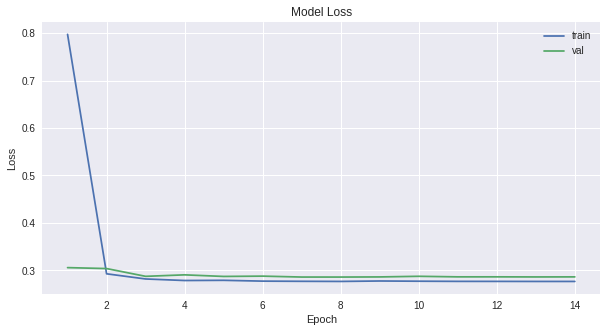

In [0]:
history = load_obj('history_siamese_model_no_emb_with brand')
plot_history(history)

In [0]:
siamese_model_without_embeddings_with_brands.load_weights(path + 'models/model37/weights.03-0.29.hdf5')

In [0]:
train_prediction = siamese_model_without_embeddings_with_brands.predict([Xtrain_search_term[train_inds], Xtrain_desc[train_inds], Xtrain_brands[train_inds]])
valid_prediction = siamese_model_without_embeddings_with_brands.predict([Xtrain_search_term[test_inds], Xtrain_desc[test_inds], Xtrain_brands[test_inds]])
test_prediction = siamese_model_without_embeddings_with_brands.predict([Xtest_search_term, Xtest_desc, Xtest_brands])
update_result_table('siamese model without emb - add brand feature ',
                    round((training_end_time-training_start_time)/60), 
                   train_prediction, y.values[train_inds],
                   valid_prediction, y.values[test_inds],
                   test_prediction, test_df.relevance.values)
results_table 

,Model type,runtime,Train RMSE,Val-RMSE,Test-RMSE,Train MAE,Val-MAE,Test-MAE
0,siamese using Google embeddings,21,0.531161,0.536808,0.536570,0.437928,0.432741,0.439500
1,siamese using Glove embeddings,21,0.532119,0.539829,0.537811,0.438348,0.434985,0.439731
2,siamese using not pretrained embeddings,12,0.532115,0.535606,0.534717,0.438177,0.430251,0.437226
3,siamese model without emb,20,0.530884,0.537128,0.534985,0.436286,0.431503,0.436756
4,siamese model without emb - add brand feature,19,0.525778,0.534760,0.530440,0.428695,0.428168,0.429952


*** as we can see we improve a little bit from 0.534 to 0.530. *** this is not enough... let's try to add some statistics features to this model

### siamese model without embedding, with brand and statistics features

In [0]:
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing

normalize:

In [0]:
train_stats = train_df.iloc[:,-5:].values
Xtrain_stats = train_stats[train_inds]
Xvalid_stats = train_stats[test_inds]
test_stats = test_df.iloc[:,-5:].values

min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler.fit(Xtrain_stats)
Xtrain_stats = preprocessing.scale(min_max_scaler.transform(Xtrain_stats))
Xvalid_stats = preprocessing.scale(min_max_scaler.transform(Xvalid_stats))
test_stats = preprocessing.scale(min_max_scaler.transform(test_stats))

In [0]:
Xtrain_stats = Xtrain_stats.reshape((Xtrain_stats.shape[0], Xtrain_stats.shape[1], 1))
Xvalid_stats = Xvalid_stats.reshape((Xvalid_stats.shape[0], Xvalid_stats.shape[1], 1))
test_stats = test_stats.reshape((test_stats.shape[0], test_stats.shape[1], 1))

print('Xtrain_stats shape: {} '.format(Xtrain_stats.shape))
print('Xvalid_stats shape: {} '.format(Xvalid_stats.shape))
print('test_stats shape: {} '.format(test_stats.shape))


Xtrain_stats shape: (53907, 5, 1) 
Xvalid_stats shape: (20160, 5, 1) 
test_stats shape: (112067, 5, 1) 


In [0]:
def build_model_without_embeddings_with_brands_and_stats():
  term_input = Input(shape=(vec_search_term,1), name='term_input')
  product_input = Input(shape=(vec_len_product_desc,1), name='product_input')
  brand_input = Input(shape=(vec_len_brands,1), name='brand_input')
  stats_input = Input(shape=(Xtrain_stats.shape[1],1), name='stats_input')
  
  con = Concatenate(axis=1)([product_input, brand_input, stats_input])
  
  shared_lstm = Sequential(name='shared_model')
  shared_lstm.add(LSTM(100, return_sequences=False))
  shared_lstm.add(Dense(100, activation='relu')) 
  shared_lstm.add(Dense(100, activation='relu'))
  
  output = Lambda(function=lambda x: 2*(exponent_neg_manhattan_distance(x[0], x[1]))+1,
                  output_shape=lambda x: (x[0][0], 1),
                  name='prediction')([shared_lstm(term_input), shared_lstm(con)])

  model = Model(inputs=[term_input,product_input, brand_input, stats_input], outputs=[output])
  optimizer = SGD(lr=0.001, momentum=0.9, nesterov=True, clipvalue=1.)
  model.compile(loss='mse', optimizer=optimizer, metrics=['mae',root_mean_squared_error])
  model.summary()
  return model

In [0]:
siamess_without_embeddings_with_brands_and_stats = build_model_without_embeddings_with_brands_and_stats()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
product_input (InputLayer)      (None, 613, 1)       0                                            
__________________________________________________________________________________________________
brand_input (InputLayer)        (None, 3, 1)         0                                            
__________________________________________________________________________________________________
stats_input (InputLayer)        (None, 5, 1)         0                                            
__________________________________________________________________________________________________
term_input (InputLayer)         (None, 18, 1)        0                                            
__________________________________________________________________________________________________
concatenat

In [0]:
training_start_time = time()
  
history = siamess_without_embeddings_with_brands_and_stats.fit([Xtrain_search_term[train_inds], Xtrain_desc[train_inds], Xtrain_brands[train_inds], Xtrain_stats], 
                                     y.values[train_inds], 
                                     validation_data=[[Xtrain_search_term[test_inds], Xtrain_desc[test_inds, Xtrain_brands[test_inds], Xvalid_stats]], y.values[test_inds]], 
                                     epochs=80, batch_size=1024, callbacks=set_callbacks(model_num = str(42)))
  
training_end_time = time()
print('running time: {}'.format((training_end_time-training_start_time)/60))

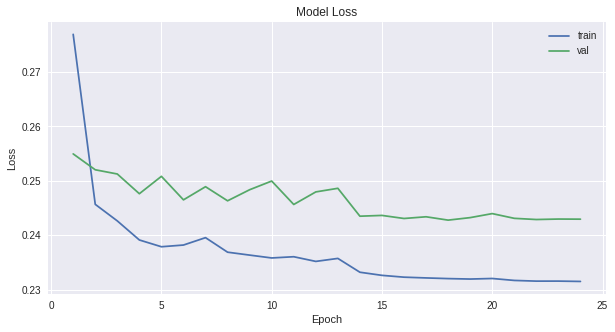

In [0]:
history = load_obj('history_siamese_model_no_emb_with brand_and_statistics')
plot_history(history)

In [0]:
siamess_without_embeddings_with_brands_and_stats.load_weights(path + 'models/model42/weights.19-0.24.hdf5')

In [0]:
train_prediction = siamess_without_embeddings_with_brands_and_stats.predict([Xtrain_search_term[train_inds], Xtrain_desc[train_inds], Xtrain_stats])
valid_prediction = siamess_without_embeddings_with_brands_and_stats.predict([Xtrain_search_term[test_inds], Xtrain_desc[test_inds], Xtrain_brands[test_inds], Xvalid_stats])
test_prediction = siamess_without_embeddings_with_brands_and_stats.predict([Xtest_search_term, Xtest_desc, Xtest_brands ,test_stats])
update_result_table('siamese model without emb - add brand and stats features ', 
                   round((training_end_time-training_start_time)/60), 
                   train_prediction, y.values[train_inds],
                   valid_prediction, y.values[test_inds],
                   test_prediction, test_df.relevance.values)
results_table 

,Model type,runtime,Train RMSE,Val-RMSE,Test-RMSE,Train MAE,Val-MAE,Test-MAE
0,siamese using Google embeddings,21,0.531161,0.536808,0.536570,0.437928,0.432741,0.439500
1,siamese using Glove embeddings,21,0.532119,0.539829,0.537811,0.438348,0.434985,0.439731
2,siamese using not pretrained embeddings,12,0.532115,0.535606,0.534717,0.438177,0.430251,0.437226
3,siamese model without emb,20,0.530884,0.537128,0.534985,0.436286,0.431503,0.436756
4,siamese model without emb - add brand feature,19,0.525778,0.534760,0.530440,0.428695,0.428168,0.429952
5,siamese model without emb - add brand and stat...,33,0.481516,0.492714,0.490126,0.390827,0.399148,0.386747


let's look at the relevance distribution:  
this time we plot it besude the real distribution , actually before this model we looked it seperatly, this way it more confort:

min pred: 1.0004302263259888 
max prediction: 2.271153450012207 



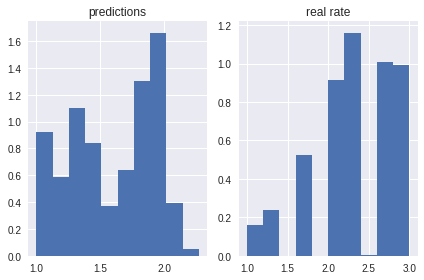

In [0]:
analyze_pred(valid_prediction,y.values[test_inds])

*** WOW!!! we improved the model rmse from 0.53 to 0.49 this is really better result !!!! ***  
becaue we are limited with time , we will suffice with this model, and try to make feature extraction and mayve et even better result!  
another intersting thing we can see is that model in compare to perior predict have many predictions on low relevance score and he doesn't predict higher than 2.27.

### feature extraction with our best model

#### form model with new output and predict our features:

we will use last layer to extract features:

In [0]:
feature_layer = siamess_without_embeddings_with_brands_and_stats.layers[-2].layers[-1].output
model_features = Model(siamese_model_no_emb.inputs, siamese_model_no_emb.layers[2].get_output_at(2))
model_features.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
product_input (InputLayer)   (None, 613, 1)            0         
_________________________________________________________________
shared_model (Sequential)    (None, 100)               61000     
Total params: 61,000
Trainable params: 61,000
Non-trainable params: 0
_________________________________________________________________


In [0]:
train_features = siamess_without_embeddings_with_brands_and_stats.predict([Xtrain_search_term[train_inds], Xtrain_desc[train_inds], Xtrain_stats])
valid_featurs = siamess_without_embeddings_with_brands_and_stats.predict([Xtrain_search_term[test_inds], Xtrain_desc[test_inds], Xtrain_brands[test_inds], Xvalid_stats])
test_features = siamess_without_embeddings_with_brands_and_stats.predict([Xtest_search_term, Xtest_desc, Xtest_brands ,test_stats])

In [0]:
train_features = load_obj('train_features_last_layer_siamese_model_no_emb')
valid_featurs = load_obj('validation_last_layer_features_siamese_model_no_emb')
test_features = load_obj('test_last_layer_features_siamese_model_no_emb')

because we didn't use batch normalization we will normalize the extracted features:

In [0]:
min_max__features_scaler = preprocessing.MinMaxScaler()
min_max__features_scaler.fit(train_features)
train_features = preprocessing.scale(min_max__features_scaler.transform(train_features))
valid_featurs = preprocessing.scale(min_max__features_scaler.transform(valid_featurs))
test_features = preprocessing.scale(min_max__features_scaler.transform(test_features))

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:176: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:193: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:176: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:193: UserWarning: Numerical issues were enc

#### make predictions with classic models:

##### xgboost

In [0]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer

In [0]:
training_start_time = time()

xgb_model = xgb.XGBRegressor(n_estimators=400,learning_rate=0.01, max_depth=8, sub_sample=0.8,colsample_bytree=0.85, seed=1)
param_grid = {
        'n_estimators': [400],
        'learning_rate': [0.01, 0.001],
        'max_depth': [6, 8],
        'subsample': [0.7, 0.8],
        'colsample_bytree': [0.8, 0.85]}

xgb_model = GridSearchCV(estimator=xgb_model, param_grid=param_grid, n_jobs=1, cv=2, verbose=2)

xgb_model.fit(train_features,y.values[train_inds].ravel())

training_end_time = time()
print('running time: {}'.format((training_end_time-training_start_time)/60))

Fitting 2 folds for each of 16 candidates, totalling 32 fits
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=400, subsample=0.7 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=400, subsample=0.7, total=  55.2s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=400, subsample=0.7 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   56.1s remaining:    0.0s


[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=400, subsample=0.7, total=  54.7s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=400, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=400, subsample=0.8, total=  53.1s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=400, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=400, subsample=0.8, total=  53.1s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=8, n_estimators=400, subsample=0.7 
[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=8, n_estimators=400, subsample=0.7, total= 1.2min
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=8, n_estimators=400, subsample=0.7 
[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=8, n_estimators=400, subsample=0.7, total= 1.2min
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=8, n_estimators=400, subsample=

[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed: 35.1min finished


running time: 36.94465317328771


In [0]:
train_prediction = xgb_model.predict(train_features)
valid_prediction = xgb_model.predict(valid_featurs)
test_prediction = xgb_model.predict(test_features)
update_result_table('XGBoost - feature extracted', 
                   round((training_end_time-training_start_time)/60), 
                   train_prediction, y.values[train_inds],
                   valid_prediction, y.values[test_inds],
                   test_prediction, test_df.relevance.values)
results_table 

,Model type,runtime,Train RMSE,Val-RMSE,Test-RMSE,Train MAE,Val-MAE,Test-MAE
0,siamese using Google embeddings,21,0.531161,0.536808,0.536570,0.437928,0.432741,0.439500
1,siamese using Glove embeddings,21,0.532119,0.539829,0.537811,0.438348,0.434985,0.439731
2,siamese using not pretrained embeddings,12,0.532115,0.535606,0.534717,0.438177,0.430251,0.437226
3,siamese model without emb,20,0.530884,0.537128,0.534985,0.436286,0.431503,0.436756
4,siamese model without emb - add brand feature,19,0.525778,0.534760,0.530440,0.428695,0.428168,0.429952
5,siamese model without emb - add brand and stat,33,0.481516,0.492714,0.490126,0.390827,0.399148,0.386747
6,XGBoost - feature extracted,37,0.490643,0.510963,0.508493,0.406271,0.413724,0.417046


min pred: 1.583115577697754 
max prediction: 2.7345025539398193 



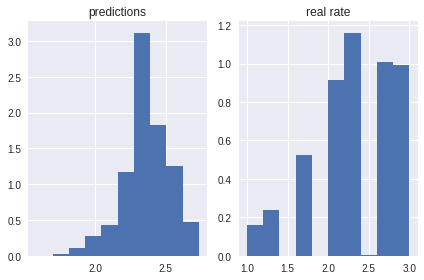

In [0]:
analyze_pred(valid_prediction,y.values[test_inds])

we can notice that this model didnt predict well extreme valuse closr to 1 or 3.

#### GradientBoostingRegressor

In [0]:
from sklearn.ensemble import GradientBoostingRegressor

In [0]:
gbr_model = GradientBoostingRegressor(random_state=1, verbose=1)
param_grid = {
        'n_estimators': [500],
        'max_features': [8,10],
        'learning_rate': [0.1,0.01],
        'subsample': [0.8,0.7]
    }
training_start_time = time()
gbr_model = GridSearchCV(estimator=gbr_model, param_grid=param_grid, n_jobs=2, cv=3, verbose=20)
gbr_model.fit(train_features,y.values[train_inds])
training_end_time = time()
print('running time: {}'.format((training_end_time-training_start_time)/60))

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   21.2s
[Parallel(n_jobs=2)]: Done   2 tasks      | elapsed:   21.8s
[Parallel(n_jobs=2)]: Done   3 tasks      | elapsed:   40.5s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:   41.6s
[Parallel(n_jobs=2)]: Done   5 tasks      | elapsed:   57.7s
[Parallel(n_jobs=2)]: Done   6 tasks      | elapsed:   59.4s
[Parallel(n_jobs=2)]: Done   7 tasks      | elapsed:  1.3min
[Parallel(n_jobs=2)]: Done   8 tasks      | elapsed:  1.3min
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:  1.7min
[Parallel(n_jobs=2)]: Done  10 tasks      | elapsed:  1.7min
[Parallel(n_jobs=2)]: Done  11 tasks      | elapsed:  2.0min
[Parallel(n_jobs=2)]: Done  12 tasks      | elapsed:  2.0min
[Parallel(n_jobs=2)]: Done  13 tasks      | elapsed:  2.3min
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:  2.3min
[Parallel(n_jobs=2)]: Done  15 tasks      | elapsed:  2.6min
[Parallel(

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.2829           0.0005           21.15s
         2           0.2830           0.0005           19.40s
         3           0.2833           0.0004           19.48s
         4           0.2821           0.0005           19.26s
         5           0.2810           0.0005           18.80s
         6           0.2807           0.0005           19.39s
         7           0.2797           0.0005           18.87s
         8           0.2806           0.0005           19.27s
         9           0.2789           0.0004           19.28s
        10           0.2782           0.0004           19.11s
        20           0.2751           0.0004           18.67s
        30           0.2712           0.0003           17.98s
        40           0.2697           0.0002           17.46s
        50           0.2674           0.0002           17.11s
        60           0.2644           0.0002           16.84s
       

In [0]:
train_prediction = gbr_model.predict(train_features)
valid_prediction = gbr_model.predict(valid_featurs)
test_prediction = gbr_model.predict(test_features)
update_result_table('GradientBoostingRegressor - feature extracted', 
                   round((training_end_time-training_start_time)/60), 
                   train_prediction, y.values[train_inds],
                   valid_prediction, y.values[test_inds],
                   test_prediction, test_df.relevance.values)
results_table 

,Model type,runtime,Train RMSE,Val-RMSE,Test-RMSE,Train MAE,Val-MAE,Test-MAE
0,siamese using Google embeddings,21,0.531161,0.536808,0.536570,0.437928,0.432741,0.439500
1,siamese using Glove embeddings,21,0.532119,0.539829,0.537811,0.438348,0.434985,0.439731
2,siamese using not pretrained embeddings,12,0.532115,0.535606,0.534717,0.438177,0.430251,0.437226
3,siamese model without emb,20,0.530884,0.537128,0.534985,0.436286,0.431503,0.436756
4,siamese model without emb - add brand feature,19,0.525778,0.534760,0.530440,0.428695,0.428168,0.429952
5,siamese model without emb - add brand and stat,33,0.481516,0.492714,0.490126,0.390827,0.399148,0.386747
6,XGBoost - feature extracted,37,0.490643,0.510963,0.508493,0.406271,0.413724,0.417046
7,GradientBoostingRegressor - feature extracted,4,0.500899,0.519252,0.510057,0.411102,0.416861,0.414542


min pred: 1.8393270983991223 
max prediction: 2.717858729944523 



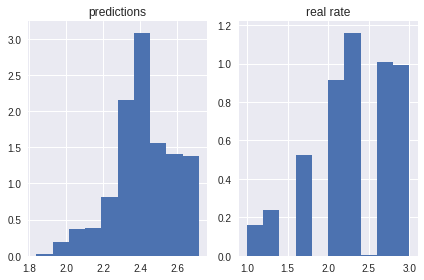

In [0]:
analyze_pred(valid_prediction,y.values[test_inds])

this prediction distribution is almost the same as the previouse one

#### RandomForest

In [0]:
from sklearn.ensemble import RandomForestRegressor

In [0]:
rfr_model = RandomForestRegressor(random_state=1, verbose=1)
param_grid = {'n_estimators': [500], 'max_features': [10, 12, 14]}
rfr_model = GridSearchCV(estimator=rfr_model, param_grid=param_grid, n_jobs=2, cv=3, verbose=20)

training_start_time = time()
rfr_model.fit(train_features,y.values[train_inds].ravel())

training_end_time = time()
print('running time: {}'.format((training_end_time-training_start_time)/60))

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:  1.8min
[Parallel(n_jobs=2)]: Done   2 tasks      | elapsed:  1.8min
[Parallel(n_jobs=2)]: Done   3 tasks      | elapsed:  3.6min
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:  3.7min
[Parallel(n_jobs=2)]: Done   5 tasks      | elapsed:  5.5min
[Parallel(n_jobs=2)]: Done   6 tasks      | elapsed:  5.7min
[Parallel(n_jobs=2)]: Done   7 out of   9 | elapsed:  7.6min remaining:  2.2min
[Parallel(n_jobs=2)]: Done   9 out of   9 | elapsed:  9.0min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   9 out of   9 | elapsed:  9.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


running time: 10.60944931904475


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  1.6min finished


In [0]:
train_prediction = rfr_model.predict(train_features)
valid_prediction = rfr_model.predict(valid_featurs)
test_prediction = rfr_model.predict(test_features)
update_result_table('RandomForest - feature extracted', 
                   round((training_end_time-training_start_time)/60), 
                   train_prediction, y.values[train_inds],
                   valid_prediction, y.values[test_inds],
                   test_prediction, test_df.relevance.values)
results_table 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   10.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   16.7s finished


,Model type,runtime,Train RMSE,Val-RMSE,Test-RMSE,Train MAE,Val-MAE,Test-MAE
0,siamese using Google embeddings,21,0.531161,0.536808,0.536570,0.437928,0.432741,0.439500
1,siamese using Glove embeddings,21,0.532119,0.539829,0.537811,0.438348,0.434985,0.439731
2,siamese using not pretrained embeddings,12,0.532115,0.535606,0.534717,0.438177,0.430251,0.437226
3,siamese model without emb,20,0.530884,0.537128,0.534985,0.436286,0.431503,0.436756
4,siamese model without emb - add brand feature,19,0.525778,0.534760,0.530440,0.428695,0.428168,0.429952
5,siamese model without emb - add brand and stat,33,0.481516,0.492714,0.490126,0.390827,0.399148,0.386747
6,XGBoost - feature extracted,37,0.490643,0.510963,0.508493,0.406271,0.413724,0.417046
7,GradientBoostingRegressor - feature extracted,4,0.500899,0.519252,0.510057,0.411102,0.416861,0.414542
8,RandomForest - feature extracted,11,0.211239,0.509951,0.514343,0.166157,0.415349,0.422507


min pred: 1.599912166666668 
max prediction: 2.8970699999999994 



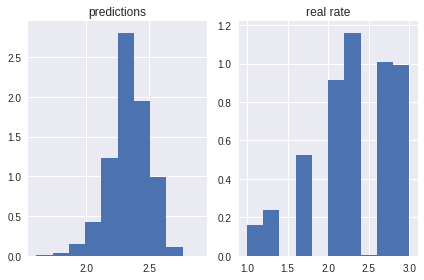

In [0]:
analyze_pred(valid_prediction,y.values[test_inds])

we can notice that for this model the distribution is broader

In [0]:
from mlxtend.regressor import StackingRegressor
from sklearn.svm import SVR

## we dont use

#### let's ensemble all together with stacking

In [0]:
from mlxtend.regressor import StackingRegressor
from mlxtend.data import boston_housing_data
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
import matplotlib.pyplot as plt
import numpy as np

In [0]:
lr = LinearRegression()
svr_lin = SVR(kernel='linear')
ridge = Ridge(random_state=1)
svr_rbf = SVR(kernel='rbf')

stregr = StackingRegressor(regressors=[svr_lin, lr, ridge], 
                           meta_regressor=svr_rbf)

stregr.fit(train_features,y.values[train_inds].ravel())


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [0]:
svr_rbf = SVR(kernel='rbf')

In [0]:
train_prediction = stregr.predict(train_features)
valid_prediction = stregr.predict(valid_featurs)
test_prediction = stregr.predict(test_features)
update_result_table('StackingRegressor - feature extracted', 
                   round((training_end_time-training_start_time)/60), 
                   train_prediction, y.values[train_inds],
                   valid_prediction, y.values[test_inds],
                   test_prediction, test_df.relevance.values)
results_table 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    9.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   16.8s finished


,Model type,runtime,Train RMSE,Val-RMSE,Test-RMSE,Train MAE,Val-MAE,Test-MAE
0,siamese using Google embeddings,21,0.531161,0.536808,0.536570,0.437928,0.432741,0.439500
1,siamese using Glove embeddings,21,0.532119,0.539829,0.537811,0.438348,0.434985,0.439731
2,siamese using not pretrained embeddings,12,0.532115,0.535606,0.534717,0.438177,0.430251,0.437226
3,siamese model without emb,20,0.530884,0.537128,0.534985,0.436286,0.431503,0.436756
4,siamese model without emb - add brand feature,19,0.525778,0.534760,0.530440,0.428695,0.428168,0.429952
5,siamese model without emb - add brand and stat,33,0.481516,0.492714,0.490126,0.390827,0.399148,0.386747
6,XGBoost - feature extracted,37,0.490643,0.510963,0.508493,0.406271,0.413724,0.417046
7,GradientBoostingRegressor - feature extracted,4,0.500899,0.519252,0.510057,0.411102,0.416861,0.414542
8,RandomForest - feature extracted,11,0.211239,0.509951,0.514343,0.166157,0.415349,0.422507
9,StackingRegressor - feature extracted,52,0.145314,0.514086,0.525644,0.095240,0.418630,0.430210


In [0]:
results_table

,Model type,runtime,Train RMSE,Val-RMSE,Test-RMSE,Train MAE,Val-MAE,Test-MAE
0,siamese using Google embeddings,21,0.531161,0.536808,0.536570,0.437928,0.432741,0.439500
1,siamese using Glove embeddings,21,0.532119,0.539829,0.537811,0.438348,0.434985,0.439731
2,siamese using not pretrained embeddings,12,0.532115,0.535606,0.534717,0.438177,0.430251,0.437226
3,siamese model without emb,20,0.530884,0.537128,0.534985,0.436286,0.431503,0.436756
4,siamese model without emb - add brand feature,19,0.525778,0.534760,0.530440,0.428695,0.428168,0.429952
5,siamese model without emb - add brand and stat,33,0.481516,0.492714,0.490126,0.390827,0.399148,0.386747


In [0]:
results_table = results_table.append(pd.Series(['siamese using Google embeddings',21,0.531161,0.536808,0.536570,0.437928,0.432741,0.439500], index = _columns),ignore_index=True)
results_table = results_table.append(pd.Series(['siamese using Glove embeddings',21,0.532119,0.539829,0.537811,0.438348,0.434985,0.439731], index = _columns),ignore_index=True)
results_table = results_table.append(pd.Series(['siamese using not pretrained embeddings',12,0.532115,0.535606,0.534717,0.438177,0.430251,0.437226], index = _columns),ignore_index=True)
results_table = results_table.append(pd.Series(['siamese model without emb',20,0.530884,0.537128,0.534985,0.436286,0.431503,0.436756], index = _columns),ignore_index=True)
results_table = results_table.append(pd.Series(['siamese model without emb - add brand feature',19,0.525778,0.534760,0.530440,0.428695,0.428168,0.429952], index = _columns),ignore_index=True)
results_table = results_table.append(pd.Series(['siamese model without emb - add brand and stat',33,0.481516,0.492714,0.490126,0.390827,0.399148,0.386747], index = _columns),ignore_index=True)
save_obj(results_table,'results_table')



In [0]:
def build_model():
  ### inputs
  inp_search_term = Input(shape=(vec_search_term,),dtype='int64')
  inp_desc = Input(shape=(vec_len_product_desc,),dtype='int64')
  #inp_material = Input(shape=(vec_len_material,),dtype='int64')
  inp_brand = Input(shape=(vec_len_brands,),dtype='int64')


  ### embeddings
  desc_emb = embedding_layer(inp_desc)
  brand_emb = embedding_layer(inp_brand)
  #material_emb = embedding_layer(inp_material)
  search_term_emb = embedding_layer(inp_search_term)

  ### siamese - one side
  con2 = Concatenate(axis=1)([desc_emb, brand_emb])# material_emb])
  lstm2 = LSTM(50, activation='relu',return_sequences = False)(con2)
  dense2 = Dense(100,activation='relu')(lstm2)
  #dense2 = Dense(100,activation='relu')(dense2)
  
  ### siamese - second side
  lstm1 = LSTM(50, activation='relu', return_sequences = False)(search_term_emb)
  dense1 = Dense(100,activation='relu')(lstm1)
  #dense1 = Dense(100,activation='relu')(dense1)

  ### similarity metric
  Mann_distance = Lambda(function=lambda x: exponent_neg_manhattan_distance(x[0], x[1]),output_shape=lambda x: (x[0][0], 1))([dense1, dense2])

  ### Model
  siamese_net = Model(inputs=[inp_search_term, inp_desc, inp_brand], outputs = Mann_distance)  #inp_material],outputs=Mann_distance)

  #siamese_net.summary()
  
  return siamese_net

In [0]:
from keras.optimizers import SGD

from keras import Sequential
def build_model_using_embeddings():
  term_input = Input(shape=(vec_search_term,), name='term_input')
  product_input = Input(shape=(vec_len_product_desc,), name='product_input')
  #brand_input = Input(shape=(vec_len_brands,1), name='brand_input')
  #statistics_input = Input(shape=(5, 1), name='statistics_input')
  embedding_layer = Embedding(len(tokenizer.word_index)+1, 100 ,weights=[embedding_vectors], trainable=True) #embedding_layer = Embedding(len(tokenizer.word_index)+1, 10)#Embedding(len(tokenizer.word_index)+1, 10) #Embedding(len(tokenizer.word_index)+1, 300 ,weights=[embedding_vectors], trainable=True)
  #con2 = Concatenate(axis=1)([product_input,brand_input])#,statistics_input])
  
  
  shared_lstm = Sequential(name='shared_model')
  shared_lstm.add(embedding_layer)
  shared_lstm.add(LSTM(100, return_sequences=False))
  #shared_lstm.add(LSTM(20, dropout=0.2, return_sequences=False))
  shared_lstm.add(Dense(100, activation='relu'))
  
 # shared_lstm.add(Dense(100, activation='relu'))

  #shared_lstm.add(Dense(150, activation='relu'))
  #shared_lstm.add(Dense(100, activation='relu'))
  
  #Mann_distance = Lambda(function=lambda x: exponent_neg_manhattan_distance(x[0], x[1]),output_shape=lambda x: (x[0][0], 1))([lstm1, lstm2])

  output = Lambda(function=lambda x: norm_to_1_3(exponent_neg_manhattan_distance(x[0], x[1])),
                  output_shape=lambda x: (x[0][0], 1),
                  name='prediction')([shared_lstm(term_input), shared_lstm(product_input)])

  #model = Model(inputs=[term_input, product_input], outputs = Mann_distance)
  model = Model(inputs=[term_input,product_input], outputs=[output])#,statistics_input], outputs=[output])
  optimizer = SGD(lr=0.001, momentum=0.9, nesterov=True, clipvalue=1.) #Adadelta(clipnorm=gradient_clipping_norm)
  model.compile(loss=root_mean_squared_error, optimizer=optimizer)
  model.summary()
  return model#0.001 is the best in model33